# Self-supervised contrastive learning on MNIST-1D

In [1]:
%matplotlib inline

import pylab as plt
import numpy as np
import torch
import time

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

# Set the seed
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Figure style
plt.style.use('https://github.com/greydanus/mnist1d/raw/master/notebooks/mpl_style.txt')

Using: cpu


In [2]:
# Load MNIST-1D

from urllib.request import urlopen
import pickle

url = 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'
data = pickle.load(urlopen(url))

print(data['x'].shape)
print(data['x_test'].shape)

(4000, 40)
(1000, 40)


In [3]:
# Classification accuracy in "pixel space"

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(data['x'], data['y'])
knn_acc = knn.score(data['x_test'], data['y_test']) * 100
print(f'kNN accuracy: {knn_acc:.1f}%')

lin = make_pipeline(StandardScaler(), LogisticRegression(tol=1e-2, max_iter=1000))
lin.fit(data['x'], data['y'])
lin_acc = lin.score(data['x_test'], data['y_test']) * 100
print(f'Linear accuracy: {lin_acc:.1f}%')

kNN accuracy: 59.6%
Linear accuracy: 32.8%


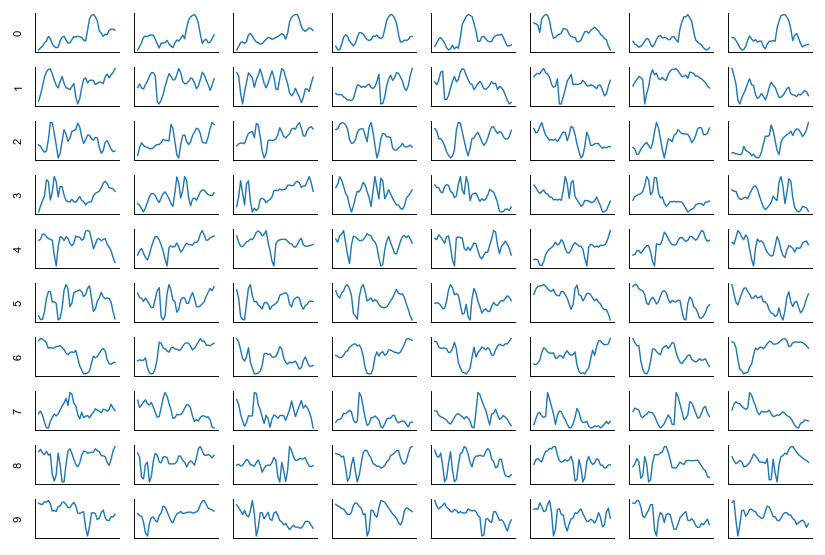

In [4]:
# Show digit examples

fig, axs = plt.subplots(nrows=10, ncols=8, figsize=(6, 4), layout='constrained')

for y in range(10):
    for i in range(8):
        axs[y, i].plot(data['x'][data['y'] == y][i])
        axs[y, i].set_xticks([])
        axs[y, i].set_yticks([])

    axs[y, 0].set_ylabel(y)

In [5]:
# Look at the distribution of means and slopes in the data
# to adjust the strength of data augmentations

offsets = data['x'].mean(axis=1)
print(f'Offsets: {offsets.mean():.2f} +- {offsets.std():.2f}')

x = data['x'] - data['x'].mean(axis=1, keepdims=True)
t = np.arange(x.shape[1]) - (x.shape[1] - 1) / 2
slopes = (x * t).sum(axis=1) / (t ** 2).sum()

print(f'Slopes:   {slopes.mean():.2f} +- {slopes.std():.2f}')

Offsets: -0.00 +- 0.30
Slopes:   0.00 +- 0.04


In [6]:
# Define data augmentations (such that it works both with numpy and pytorch)

def augment(x, offsets_std=0.3, slopes_std=0.04, maxshift=40, mode='numpy'):
    lib = torch if mode=='pytorch' else np
    n = x.shape[0]

    if mode=='pytorch':
        x_new = x.detach().clone()
    else:
        x_new = x.copy()

    # Subtract offsets
    x_new = x_new - x_new.mean(axis=1, keepdims=True)

    # De-trend
    if mode=='pytorch':
        t = torch.arange(x.shape[1], device=x.device) - (x.shape[1] - 1) / 2
    else:
        t = np.arange(x.shape[1]) - (x.shape[1] - 1) / 2
    slopes = (x * t).sum(axis=1) / (t ** 2).sum()
    x_new -= slopes[:, None] * t

    # Circular shift
    if maxshift > 0:
        shifts = np.random.randint(0, maxshift, size=(n,))
        for i in range(x.shape[0]):
            x_new[i] = lib.roll(x_new[i], shifts[i])

    # Generate random slopes and offsets
    if mode=='pytorch':
        slopes = torch.normal(0, slopes_std, size=(n, 1), device=x.device)
        offsets = torch.normal(0, offsets_std, size=(n, 1), device=x.device)
    else:
        slopes = np.random.normal(0, slopes_std, size=(n, 1))
        offsets = np.random.normal(0, offsets_std, size=(n, 1))
    x_new += slopes * t
    x_new += offsets
    
    return x_new

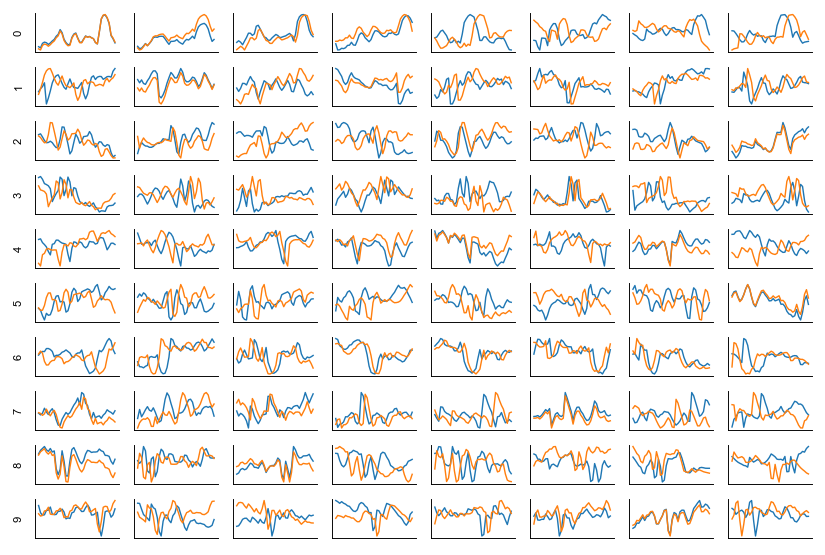

In [7]:
# Plot twice augmented data

fig, axs = plt.subplots(nrows=10, ncols=8, figsize=(6, 4), layout='constrained')

set_seed(42)

aug_data_1 = augment(data['x'], maxshift=10)
aug_data_2 = augment(data['x'], maxshift=10)

for y in range(10):
    for i in range(8):
        axs[y, i].plot(aug_data_1[data['y'] == y][i])
        axs[y, i].plot(aug_data_2[data['y'] == y][i])
        axs[y, i].set_xticks([])
        axs[y, i].set_yticks([])

    axs[y, 0].set_ylabel(y)

In [8]:
# Define model

class SimCLR(torch.nn.Module):
    def __init__(self, output_dim=16, channels=25, hidden_dim=125, verbose=True):
        super(SimCLR, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, channels, 5, stride=2, padding=1)
        self.conv2 = torch.nn.Conv1d(channels, channels, 3, stride=2, padding=1)
        self.conv3 = torch.nn.Conv1d(channels, channels, 3, stride=2, padding=1)
        self.linear1 = torch.nn.Linear(channels * 5, hidden_dim)   # 125D
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)

        if verbose:
            print("Initialized CNN with {} parameters".format(self.count_params()))

    def count_params(self):
        return sum([p.view(-1).shape[0] for p in self.parameters()])

    def forward(self, x, projector=True, all_layers=False):
        x = x.view(-1, 1, x.shape[-1])
        h1 = self.conv1(x).relu()
        h2 = self.conv2(h1).relu()
        h3 = self.conv3(h2).relu()
        h3 = h3.view(h3.shape[0], -1) # flatten the conv features (125D)

        if not projector:
            return h3

        p1 = self.linear1(h3).relu()
        p2 = self.linear2(p1)
        
        if all_layers:
            return [h1.view(h1.shape[0], -1), h2.view(h1.shape[0], -1), h3, p1, p2]
        
        return p2

In [9]:
# Set up contrastive training

def contrastive_train(dataset, model, lr=0.01, n_epochs=100, batch_size=100,
                      tau=0.5, print_every_epoch=10, maxshift=10):

    optimizer = torch.optim.Adam(model.parameters(), lr)

    x = torch.Tensor(dataset['x']).to(DEVICE)
    x_test = torch.Tensor(dataset['x_test']).to(DEVICE)
    model = model.to(DEVICE)

    knn_acc = np.nan
    lin_acc = np.nan
        
    t0 = time.time()
    for epoch in range(n_epochs):
        acc_loss = 0

        shuffle = np.random.permutation(len(x))

        for batch in range(len(x) // batch_size):
            batch_ind = np.arange(batch * batch_size, (batch + 1) * batch_size)
                
            # Augmenting the batch twice
            x_augm1 = augment(x[shuffle][batch_ind], mode='pytorch', maxshift=maxshift)
            x_augm2 = augment(x[shuffle][batch_ind], mode='pytorch', maxshift=maxshift)

            # Pass both views through the model
            out1 = model(x_augm1)
            out2 = model(x_augm2)

            # Note: this uses half-batch repulsion instead of full-batch
            o1 = torch.nn.functional.normalize(out1)
            o2 = torch.nn.functional.normalize(out2)
            scores = torch.matmul(o1, torch.t(o2))
            sims = torch.exp(scores / tau)

            # InfoNCE loss function
            loss = torch.mean(-torch.log(torch.diag(sims)) + torch.log(torch.sum(sims, axis=1)))

            acc_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Evaluate and print
        if (epoch + 1) % print_every_epoch == 0:
            t1 = time.time()
            mean_loss = acc_loss / (len(x) // batch_size)
            mean_time = (t1 - t0) / print_every_epoch

            # Compute test set classification accuracy
            model.eval()
            with torch.no_grad():
                knn = KNeighborsClassifier(n_neighbors=10, metric='cosine')
                knn.fit(model(x).detach().numpy(), dataset['y'])
                knn_acc = knn.score(model(x_test).detach().numpy(), dataset['y_test']) * 100

                lin = make_pipeline(StandardScaler(), LogisticRegression(tol=1e-2, max_iter=1000))
                lin.fit(model(x, projector=False).detach().numpy(), dataset['y'])
                lin_acc = lin.score(model(x_test, projector=False).detach().numpy(), dataset['y_test']) * 100
            model.train()

            print(f'Epoch {epoch + 1:3.0f}, loss per batch {mean_loss:.2f}, val kNN acc Z: {knn_acc:4.1f}, val lin acc H: {lin_acc:4.1f}, time per epoch {mean_time:.1f}s')
            t0 = t1

    return acc_loss / (len(x) // batch_size), knn_acc, lin_acc

In [10]:
# Train the model and pass the entire dataset through it (before/after)

set_seed(42)

model = SimCLR(output_dim=16)

Z0 = model(torch.Tensor(data['x']).to(DEVICE)).detach().numpy()

contrastive_train(data, model, n_epochs=200, tau=0.5, batch_size=100, maxshift=10)

Z = model(torch.Tensor(data['x']).to(DEVICE)).detach().numpy()
H = model(torch.Tensor(data['x']).to(DEVICE), projector=False).detach().numpy()

Initialized CNN with 21716 parameters
Epoch  10, loss per batch 3.11, val kNN acc Z: 59.0, val lin acc H: 71.4, time per epoch 0.2s
Epoch  20, loss per batch 3.02, val kNN acc Z: 65.5, val lin acc H: 75.1, time per epoch 0.3s
Epoch  30, loss per batch 2.99, val kNN acc Z: 67.9, val lin acc H: 79.9, time per epoch 0.3s
Epoch  40, loss per batch 2.98, val kNN acc Z: 69.9, val lin acc H: 81.0, time per epoch 0.3s
Epoch  50, loss per batch 2.97, val kNN acc Z: 70.0, val lin acc H: 81.8, time per epoch 0.4s
Epoch  60, loss per batch 2.95, val kNN acc Z: 70.6, val lin acc H: 81.4, time per epoch 0.4s
Epoch  70, loss per batch 2.93, val kNN acc Z: 72.1, val lin acc H: 81.6, time per epoch 0.4s
Epoch  80, loss per batch 2.93, val kNN acc Z: 73.4, val lin acc H: 81.5, time per epoch 0.4s
Epoch  90, loss per batch 2.92, val kNN acc Z: 72.7, val lin acc H: 82.1, time per epoch 0.4s
Epoch 100, loss per batch 2.92, val kNN acc Z: 73.5, val lin acc H: 82.6, time per epoch 0.4s
Epoch 110, loss per ba

In [11]:
# Visualise using t-SNE

T  = TSNE(metric='cosine', n_jobs=-1, square_distances=True).fit_transform(Z)
T0 = TSNE(metric='cosine', n_jobs=-1, square_distances=True).fit_transform(Z0)

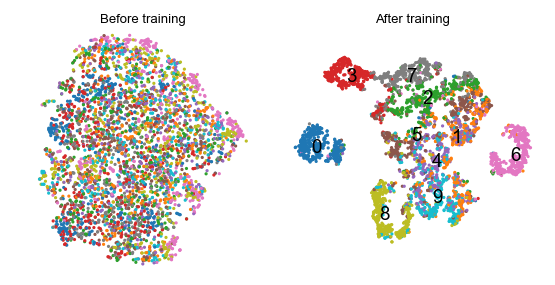

In [12]:
# Plot the visualisation

fig, axs = plt.subplots(ncols=2, figsize=(4, 2), layout='constrained')

axs[0].scatter(T0[:,0], T0[:,1], c=data['y'], s=2, cmap='tab10')
axs[0].set_aspect('equal', 'datalim')
axs[0].set_title('Before training')
axs[0].axis('off')

axs[1].scatter(T[:,0], T[:,1], c=data['y'], s=2, cmap='tab10')
axs[1].set_aspect('equal', 'datalim')
axs[1].set_title('After training')
axs[1].axis('off')

for y in range(10):
    mu = np.median(T[data['y'] == y], axis=0)
    axs[1].text(mu[0], mu[1], y, fontsize=10, ha='center', va='center')

In [13]:
# Evaluate every layer

lin = make_pipeline(StandardScaler(), LogisticRegression(tol=1e-2, max_iter=1000))

L_train = model(torch.Tensor(data['x']), all_layers=True)
L_train = [l.detach().numpy() for l in L_train]
L_train = [data['x']] + L_train

L_test = model(torch.Tensor(data['x_test']), all_layers=True)
L_test = [l.detach().numpy() for l in L_test]
L_test = [data['x_test']] + L_test

acc = np.zeros(len(L_train))

for i in range(len(L_train)):
    lin.fit(L_train[i], data['y'])
    acc[i] = lin.score(L_test[i], data['y_test']) * 100
    print(f'Layer {i}: linear accuracy {acc[i]:.1f}')

Layer 0: linear accuracy 32.8
Layer 1: linear accuracy 75.6
Layer 2: linear accuracy 83.0
Layer 3: linear accuracy 81.5
Layer 4: linear accuracy 78.6
Layer 5: linear accuracy 75.8


In [14]:
# Model without a projector (only convolutional layers)

class SimCLR_noprojector(torch.nn.Module):
    def __init__(self, output_dim=16, channels=25, hidden_dim=125, verbose=True):
        super(SimCLR_noprojector, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, channels, 5, stride=2, padding=1)
        self.conv2 = torch.nn.Conv1d(channels, channels, 3, stride=2, padding=1)
        self.conv3 = torch.nn.Conv1d(channels, channels, 3, stride=2, padding=1)

        if verbose:
            print("Initialized CNN with {} parameters".format(self.count_params()))

    def count_params(self):
        return sum([p.view(-1).shape[0] for p in self.parameters()])

    def forward(self, x, projector=True, all_layers=False):
        x = x.view(-1, 1, x.shape[-1])
        h1 = self.conv1(x).relu()
        h2 = self.conv2(h1).relu()
        h3 = self.conv3(h2).relu()
        h3 = h3.view(h3.shape[0], -1) # flatten the conv features (125D)
        
        if all_layers:
            return [h1.view(h1.shape[0], -1), h2.view(h1.shape[0], -1), h3]
        
        return h3

In [15]:
# Train

set_seed(42)
model_noprojector = SimCLR_noprojector()
contrastive_train(data, model_noprojector, n_epochs=200, tau=0.5, batch_size=100, maxshift=10);

Initialized CNN with 3950 parameters
Epoch  10, loss per batch 3.57, val kNN acc Z: 50.7, val lin acc H: 51.7, time per epoch 0.3s
Epoch  20, loss per batch 3.49, val kNN acc Z: 62.0, val lin acc H: 61.1, time per epoch 0.4s
Epoch  30, loss per batch 3.43, val kNN acc Z: 53.3, val lin acc H: 56.6, time per epoch 0.4s
Epoch  40, loss per batch 3.41, val kNN acc Z: 56.5, val lin acc H: 60.7, time per epoch 0.4s
Epoch  50, loss per batch 3.41, val kNN acc Z: 55.6, val lin acc H: 56.8, time per epoch 0.4s
Epoch  60, loss per batch 3.40, val kNN acc Z: 58.7, val lin acc H: 56.5, time per epoch 0.4s
Epoch  70, loss per batch 3.38, val kNN acc Z: 52.9, val lin acc H: 56.0, time per epoch 0.4s
Epoch  80, loss per batch 3.39, val kNN acc Z: 58.5, val lin acc H: 56.1, time per epoch 0.4s
Epoch  90, loss per batch 3.37, val kNN acc Z: 56.9, val lin acc H: 58.7, time per epoch 0.5s
Epoch 100, loss per batch 3.37, val kNN acc Z: 56.1, val lin acc H: 57.6, time per epoch 0.5s
Epoch 110, loss per bat

In [16]:
# Evaluate 

lin = make_pipeline(StandardScaler(), LogisticRegression(tol=1e-2, max_iter=1000))

L_train = model_noprojector(torch.Tensor(data['x']), all_layers=True)
L_train = [l.detach().numpy() for l in L_train]
L_train = [data['x']] + L_train

L_test = model_noprojector(torch.Tensor(data['x_test']), all_layers=True)
L_test = [l.detach().numpy() for l in L_test]
L_test = [data['x_test']] + L_test

acc_noprojector = np.zeros(len(L_train))

for i in range(len(L_train)):
    lin.fit(L_train[i], data['y'])
    acc_noprojector[i] = lin.score(L_test[i], data['y_test']) * 100
    print(f'Layer {i}: linear accuracy {acc_noprojector[i]:.1f}')

Layer 0: linear accuracy 32.8
Layer 1: linear accuracy 84.6
Layer 2: linear accuracy 78.2
Layer 3: linear accuracy 54.1


In [17]:
# Model with a deper projector

class SimCLR_deepprojector(torch.nn.Module):
    def __init__(self, output_dim=16, channels=25, hidden_dim=125, verbose=True):
        super(SimCLR_deepprojector, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, channels, 5, stride=2, padding=1)
        self.conv2 = torch.nn.Conv1d(channels, channels, 3, stride=2, padding=1)
        self.conv3 = torch.nn.Conv1d(channels, channels, 3, stride=2, padding=1)
        self.linear1 = torch.nn.Linear(channels * 5, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = torch.nn.Linear(hidden_dim, output_dim)

        if verbose:
            print("Initialized CNN with {} parameters".format(self.count_params()))

    def count_params(self):
        return sum([p.view(-1).shape[0] for p in self.parameters()])

    def forward(self, x, projector=True, all_layers=False):
        x = x.view(-1, 1, x.shape[-1])
        h1 = self.conv1(x).relu()
        h2 = self.conv2(h1).relu()
        h3 = self.conv3(h2).relu()
        h3 = h3.view(h3.shape[0], -1) # flatten the conv features (125D)

        if not projector:
            return h3

        p1 = self.linear1(h3).relu()
        p2 = self.linear2(p1).relu()
        p3 = self.linear3(p2).relu()
        p4 = self.linear4(p3)
        
        if all_layers:
            return [h1.view(h1.shape[0], -1), h2.view(h1.shape[0], -1), h3, p1, p2, p3, p4]
        
        return p4

In [18]:
# Train

set_seed(42)
model_deepprojector = SimCLR_deepprojector()
contrastive_train(data, model_deepprojector, n_epochs=200, tau=0.5, batch_size=100, maxshift=10);

Initialized CNN with 53216 parameters
Epoch  10, loss per batch 3.26, val kNN acc Z: 27.5, val lin acc H: 65.9, time per epoch 0.6s
Epoch  20, loss per batch 3.08, val kNN acc Z: 43.4, val lin acc H: 72.4, time per epoch 0.7s
Epoch  30, loss per batch 3.00, val kNN acc Z: 45.0, val lin acc H: 75.2, time per epoch 0.7s
Epoch  40, loss per batch 2.99, val kNN acc Z: 48.8, val lin acc H: 76.7, time per epoch 0.7s
Epoch  50, loss per batch 2.95, val kNN acc Z: 50.4, val lin acc H: 78.6, time per epoch 0.6s
Epoch  60, loss per batch 2.94, val kNN acc Z: 49.0, val lin acc H: 81.3, time per epoch 0.6s
Epoch  70, loss per batch 2.92, val kNN acc Z: 52.4, val lin acc H: 81.1, time per epoch 0.6s
Epoch  80, loss per batch 2.92, val kNN acc Z: 53.9, val lin acc H: 82.2, time per epoch 0.6s
Epoch  90, loss per batch 2.91, val kNN acc Z: 55.1, val lin acc H: 82.4, time per epoch 0.5s
Epoch 100, loss per batch 2.90, val kNN acc Z: 55.7, val lin acc H: 82.9, time per epoch 0.5s
Epoch 110, loss per ba

In [19]:
# Evaluate 

lin = make_pipeline(StandardScaler(), LogisticRegression(tol=1e-2, max_iter=1000))

L_train = model_deepprojector(torch.Tensor(data['x']), all_layers=True)
L_train = [l.detach().numpy() for l in L_train]
L_train = [data['x']] + L_train

L_test = model_deepprojector(torch.Tensor(data['x_test']), all_layers=True)
L_test = [l.detach().numpy() for l in L_test]
L_test = [data['x_test']] + L_test

acc_deepprojector = np.zeros(len(L_train))

for i in range(len(L_train)):
    lin.fit(L_train[i], data['y'])
    acc_deepprojector[i] = lin.score(L_test[i], data['y_test']) * 100
    print(f'Layer {i}: linear accuracy {acc_deepprojector[i]:.1f}')

Layer 0: linear accuracy 32.8
Layer 1: linear accuracy 76.5
Layer 2: linear accuracy 85.1
Layer 3: linear accuracy 84.4
Layer 4: linear accuracy 78.4
Layer 5: linear accuracy 74.1
Layer 6: linear accuracy 65.9
Layer 7: linear accuracy 62.0


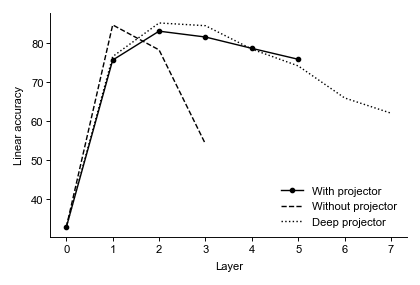

In [20]:
# Plot, for all three models

fig = plt.figure(figsize=(3, 2), layout='constrained')

plt.plot(acc, 'k.-', label='With projector')
plt.plot(acc_noprojector, 'k--', label='Without projector')
plt.plot(acc_deepprojector, 'k:', label='Deep projector')
plt.xlabel('Layer')
plt.ylabel('Linear accuracy')
plt.legend();

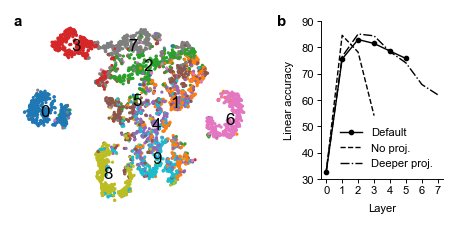

In [21]:
# Set up the final figure

fig = plt.figure(figsize=(6.5/2, 1.5), layout=None)

axs[0] = plt.axes([0, 0, .55, 1])
axs[1] = plt.axes([.7, .18, .28, .78])

axs[0].scatter(T[:,0], T[:,1], c=data['y'], s=2, cmap='tab10')
axs[0].set_aspect('equal', 'datalim')
axs[0].axis('off')

for y in range(10):
    mu = np.median(T[data['y'] == y], axis=0)
    axs[0].text(mu[0], mu[1], y, fontsize=9, ha='center', va='center')
    
axs[1].plot(acc, 'k.-', label='Default')
axs[1].plot(acc_noprojector, 'k--', markersize=2, label='No proj.')
axs[1].plot(acc_deepprojector, 'k-.', markersize=2, label='Deeper proj.')
axs[1].set_xlabel('Layer')
axs[1].set_ylabel('Linear accuracy')
axs[1].set_xticks([0,1,2,3,4,5,6,7])
axs[1].set_ylim([30, 90])
axs[1].legend()

fig.text(0, .94, 'a', fontsize=8, weight='bold')
fig.text(.6, .94, 'b', fontsize=8, weight='bold')

# Ignore annoying savefig warnings (not sure why I am getting them)
import warnings
warnings.filterwarnings('ignore')

fig.savefig('figures/ssl.png', dpi=300)
fig.savefig('figures/ssl.pdf')